In [1]:
# new accuracy
import collections

import compress_pickle
import copy
import editdistance
import itertools
import libsbml
import numpy as np
import os
import pickle
import pandas as pd
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline  

BIOMD_12 = 'BIOMD0000000012.xml'
BASE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/'
DATA_DIR = os.path.join(BASE_DIR, "DATA")
ALGO_DIR = os.path.join(DATA_DIR, "algo")
CHEBI_DIR = os.path.join(DATA_DIR, "chebi")
FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
RHEA_DIR = os.path.join(DATA_DIR, "rhea")
BIOMODEL_DIR = os.path.join(DATA_DIR, "biomodels/curated_biomodels_31mar2021")
BIGG_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/DATA/bigg'
ecoli_fpath = os.path.join(BIGG_DIR, "e_coli_core.xml")

PROJ_DIR = os.path.join(os.getcwd(), os.pardir)
AMAS_DIR = os.path.join(PROJ_DIR, "AMAS")
sys.path.append(PROJ_DIR)

SUPPL_DIR = os.path.join(PROJ_DIR, os.pardir, "AMAS_suppl")
ACCURACY_DIR = os.path.join(SUPPL_DIR, "data_for_credibility")

from AMAS import species_annotation as sa
from AMAS import reaction_annotation as ra
from AMAS import recommender
from AMAS import constants as cn
from AMAS import iterator as it
from AMAS import tools

In [2]:
a_few_biomds = ['BIOMD0000000002.xml',
                'BIOMD0000000013.xml',
                'BIOMD0000000015.xml',
                'BIOMD0000000017.xml',
                'BIOMD0000000018.xml']

In [25]:
spec_ml_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_species_accuracy.csv'))

spec_ml_df.tail()

,model,name_length,num_candidates,num_formulas,match_score,accuracy
4897,BIOMD0000000177.xml,4,1,1,1.000,1
4898,BIOMD0000000177.xml,8,1,1,1.000,1
4899,BIOMD0000000177.xml,9,2,1,1.000,1
4900,BIOMD0000000177.xml,9,1,1,1.000,1
4901,BIOMD0000000177.xml,7,1,1,0.867,0


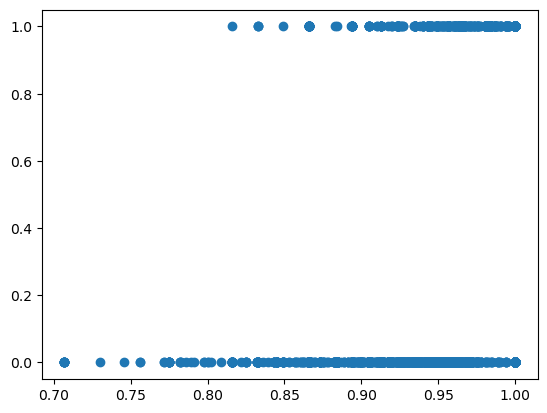

In [4]:
degen_val = 1
df = spec_ml_df[spec_ml_df['name_length']>degen_val]

plt.scatter(df['match_score'], df['accuracy'])

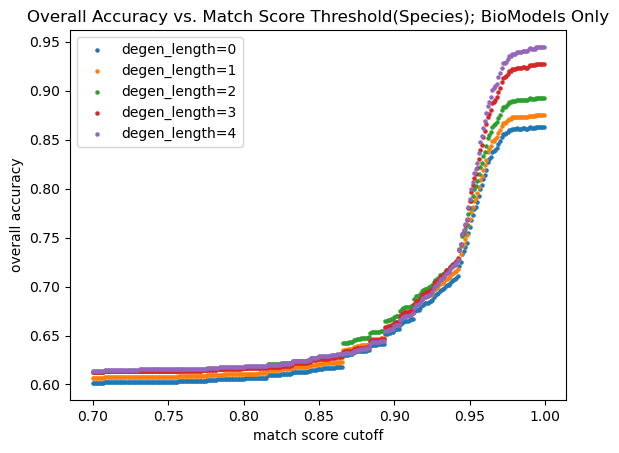

In [5]:
cutoffs = np.arange(0.7, 1.05, step=0.001)

one_degen = 4
vals = dict()

for one_degen in range(0, 5):
  ys = []
  xs = []
  val_tuples = []
  df = spec_ml_df[spec_ml_df['name_length']>one_degen]
  for one_c in cutoffs:
    xs.append(one_c)
    sub_df = df[df['match_score']>=one_c]
    prop_accuracy = np.mean(sub_df['accuracy'])
    ys.append(prop_accuracy)
    val_tuples.append((one_c, prop_accuracy))
  vals[str(one_degen)] = val_tuples
  plt.scatter(xs, ys, s=5, label='degen_length=%d'%one_degen)
plt.legend()
plt.xlabel('match score cutoff')
plt.ylabel('overall accuracy')
plt.title("Overall Accuracy vs. Match Score Threshold(Species); BioModels Only")


FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')
plt.savefig(os.path.join(TEMPFIG_DIR, 'accuracy_vs_score_species_biomd_only.png'), dpi=300,
            bbox_inches='tight', pad_inches=0.0)

In [6]:
np.min(df['match_score'])

0.707

In [7]:
# TODO: (1) DO THE SAME THING WITH (one bigg model with about 1000 species?!
# as 108/306 models wanted to be added
# (2) do the same two plots of reactions

In [8]:
biggs = [val for val in os.listdir(BIGG_DIR) if val[-4:]=='.xml']
len(biggs)

108

In [110]:
num_bigg_specs = []
num_bigg_reacs = []
for idx, one_biomd in enumerate(biggs):
  if idx % 30 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIGG_DIR, one_biomd)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  specs2evaluate = list(recom.species.exist_annotation_formula.keys())
  reacs2evaluate = list(recom.reactions.exist_annotation.keys())
  num_bigg_specs.append(len(specs2evaluate))
  num_bigg_reacs.append(len(reacs2evaluate))

We are at 0
We are at 30
We are at 60
We are at 90


In [152]:
bigg_df = pd.DataFrame(zip(biggs, num_bigg_specs, num_bigg_reacs), columns=['model', 'species', 'reactions'])
bigg_df.head()

,model,species,reactions
0,iCHOv1.xml,2172,1645
1,iYL1228.xml,1359,1263
2,iIS312.xml,482,232
3,iSDY_1059.xml,1468,1303
4,iEC1356_Bl21DE3.xml,1478,1423


In [10]:
model_names = []
len_names = []
num_cands = []
num_formulas = []
match_scores = []
is_correct_included = []
#
one_bigg = 'iMM904.xml'
one_fpath = os.path.join(BIGG_DIR, one_bigg)
recom = recommender.Recommender(libsbml_fpath=one_fpath)
specs2evaluate = list(recom.species.exist_annotation_formula.keys())

recoms = recom.getSpeciesListRecommendation(pred_ids=recom.species.exist_annotation_formula.keys())
recalls = recom.getSpeciesStatistics(model_mean=False)[cn.RECALL]
for one_recom in recoms:
  model_names.append(one_bigg)
  one_spec = one_recom.id
  len_names.append(len(recom.species.getNameToUse(one_spec)))
  num_cands.append(len(one_recom.candidates))
  num_formulas.append(len(recom.species.formula[one_recom.id]))
  match_scores.append(one_recom.candidates[0][1])
  if recalls[one_spec] > 0:
    is_correct_included.append(1)
  else:
    is_correct_included.append(0)
    
spec_df_add = pd.DataFrame({'model': model_names,
                            'name_length': len_names,
                            'num_candidates': num_cands,
                            'num_formulas': num_formulas,
                            'match_score': match_scores,
                            'accuracy': is_correct_included})

(array([278., 363., 254.,  85.,  34.,  12.,   0.,   1.,   2.,   1.]),
 array([  2. ,  11.8,  21.6,  31.4,  41.2,  51. ,  60.8,  70.6,  80.4,
         90.2, 100. ]),
 <BarContainer object of 10 artists>)

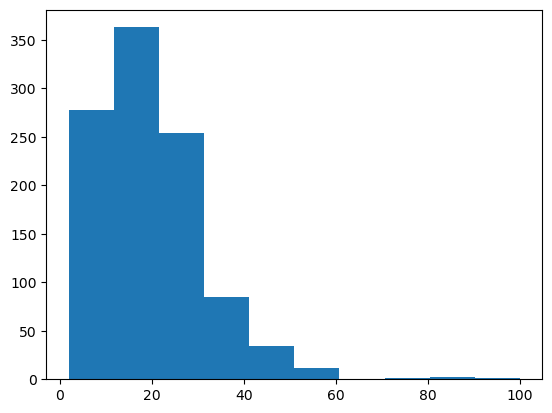

In [11]:
plt.hist(spec_df_add['name_length'])

(5932, 6)


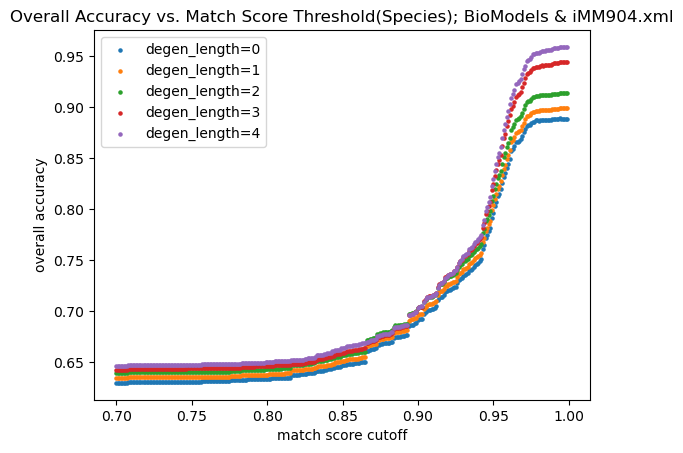

In [30]:
spec_ml_df2 = pd.concat([spec_ml_df, spec_df_add])
print(spec_ml_df2.shape)

cutoffs = np.arange(0.7, 1.05, step=0.001)

one_degen = 4
vals = dict()

for one_degen in range(0, 5):
  ys = []
  xs = []
  val_tuples = []
  df = spec_ml_df2[spec_ml_df2['name_length']>one_degen]
  for one_c in cutoffs:
    xs.append(one_c)
    sub_df = df[df['match_score']>=one_c]
    prop_accuracy = np.mean(sub_df['accuracy'])
    ys.append(prop_accuracy)
    val_tuples.append((one_c, prop_accuracy))
  vals[str(one_degen)] = val_tuples
  plt.scatter(xs, ys, s=5, label='degen_length=%d'%one_degen)
plt.legend()
plt.xlabel('match score cutoff')
plt.ylabel('overall accuracy')
plt.title("Overall Accuracy vs. Match Score Threshold(Species); BioModels & iMM904.xml")

# print([val for val in val_tuples if val[1]>=0.95][0])
FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')
plt.savefig(os.path.join(TEMPFIG_DIR, 'accuracy_vs_score_species_biomd_iMM904.png'), dpi=300,
            bbox_inches='tight', pad_inches=0.0)

In [37]:
[k for k in vals['3'] if k[1]>=0.95]

[]

In [13]:
reac_ml_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'biomd_individual_reactions_accuracy.csv'))
reac_ml_df.tail()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
2183,BIOMD0000000177.xml,5.923077,4,13,0.522385,1
2184,BIOMD0000000177.xml,6.813559,3,59,0.300085,0
2185,BIOMD0000000177.xml,4.750000,4,4,0.450000,1
2186,BIOMD0000000177.xml,6.042553,3,47,0.523255,1
2187,BIOMD0000000177.xml,6.000000,3,1,0.333000,0


(array([ 25., 640.,   0., 476.,   0., 762., 105.,   0., 159.,  21.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

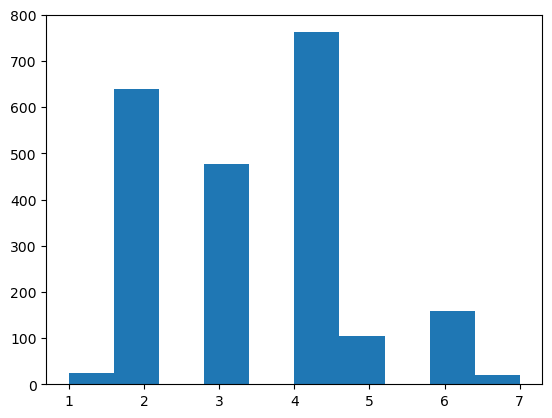

In [14]:
plt.hist(reac_ml_df['num_query_elements'])

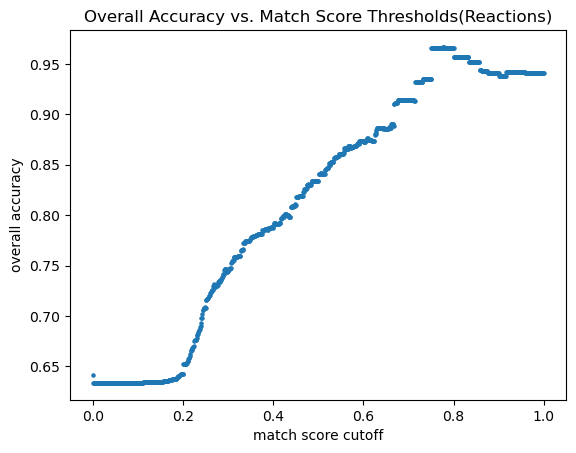

In [15]:
cutoffs = np.arange(0.0, 1.05, step=0.001)
ys = []
xs = []
val_tuples = []
# degen_val = 4
# df = spec_ml_df[spec_ml_df['name_length']>degen_val]
df2 = copy.deepcopy(reac_ml_df)

for one_c in cutoffs:
  xs.append(one_c)
  sub_df = df2[df2['match_score']>=one_c]
  prop_accuracy = np.mean(sub_df['accuracy'])
  ys.append(prop_accuracy)
  val_tuples.append((one_c, prop_accuracy))
# plt.ylim([0.65,0.95])
# plt.yticks(np.arange(0.65, 0.95, step=0.025))
plt.scatter(xs, ys, s=5)
# plt.legend()
plt.xlabel('match score cutoff')
plt.ylabel('overall accuracy')
plt.title("Overall Accuracy vs. Match Score Thresholds(Reactions)")

# FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
# TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')
# plt.savefig(os.path.join(TEMPFIG_DIR, 'accuracy_vs_score_reaction_biomd_only.png'), dpi=300,
#             bbox_inches='tight', pad_inches=0.0)

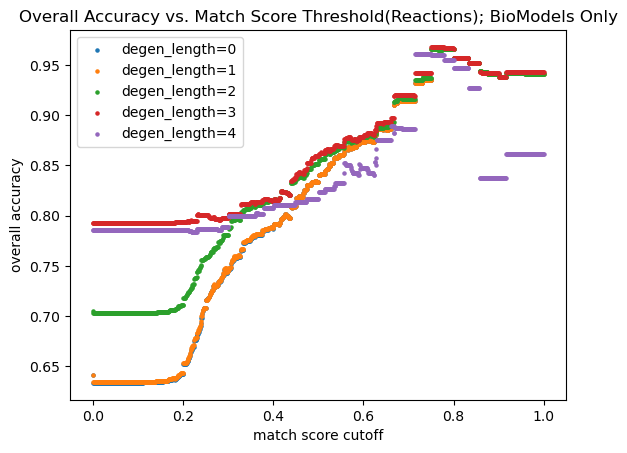

In [20]:
cutoffs = np.arange(0.0, 1.05, step=0.001)
vals = dict()
for one_degen in range(0, 5):
  ys = []
  xs = []
  val_tuples = []
  df = reac_ml_df[reac_ml_df['num_query_elements']>one_degen]
  for one_c in cutoffs:
    xs.append(one_c)
    sub_df = df[df['match_score']>=one_c]
    prop_accuracy = np.mean(sub_df['accuracy'])
    ys.append(prop_accuracy)
    val_tuples.append((one_c, prop_accuracy))
  vals[str(one_degen)] = val_tuples
  plt.scatter(xs, ys, s=5, label='degen_length=%d'%one_degen)
plt.legend()
plt.xlabel('match score cutoff')
plt.ylabel('overall accuracy')
plt.title("Overall Accuracy vs. Match Score Threshold(Reactions); BioModels Only")


FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')
plt.savefig(os.path.join(TEMPFIG_DIR, 'accuracy_vs_score_reactions_biomd_only.png'), dpi=300,
            bbox_inches='tight', pad_inches=0.0)

In [17]:
# Using the additional bigg model;
def getRheaElementNum(inp_rhea, inp_df=ra.REF_MAT):
  """
  Get Number of elements of
  the given rhea term.
  
  Parameters
  ----------
  inp_rhea: str
  
  Returns
  -------
  : int
  """
  return len(inp_df.loc[inp_rhea, :].to_numpy().nonzero()[0])

model_names = []
num_rhea_eles = []
num_query_eles = []
num_candidates = []
val_match_scores = []
is_correct_included = []


one_bigg = 'iMM904.xml'
one_fpath = os.path.join(BIGG_DIR, one_bigg)
recom = recommender.Recommender(libsbml_fpath=one_fpath)
reac2evaluate = list(recom.reactions.exist_annotation.keys())
recoms = recom.getReactionListRecommendation(pred_ids=reac2evaluate)
recalls = recom.getReactionStatistics(model_mean=False)[cn.RECALL]
for one_recom in recoms:
  reaction_id = one_recom.id
  match_scores = [val[1] for val in one_recom.candidates]
  num_ref_elements = [getRheaElementNum(val[0]) for val in one_recom.candidates]
  #
  mean_num_rhea_elements = np.mean(num_ref_elements)   
  # this is actually the number of reaction components;
  num_query_ele = len(recom.reactions.reaction_components[reaction_id])
  num_cands = len(match_scores)
  mean_match_score = np.mean(match_scores)
  #
  model_names.append(one_bigg)
  num_rhea_eles.append(mean_num_rhea_elements)
  num_query_eles.append(num_query_ele)
  num_candidates.append(num_cands)
  val_match_scores.append(mean_match_score)
  if recalls[reaction_id] > 0.0:
    is_correct_included.append(1)
  else:
    is_correct_included.append(0)
    
reac_df_add = pd.DataFrame({'model': model_names,
                            'mean_num_rhea_elements': num_rhea_eles,
                            'num_query_elements': num_query_eles,
                            'num_candidates': num_candidates,
                            'match_score': val_match_scores,
                            'accuracy': is_correct_included})
reac_df_add.head()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
0,iMM904.xml,4.0,4,1,1.00,1
1,iMM904.xml,5.0,5,2,0.80,0
2,iMM904.xml,4.0,4,3,0.75,1
3,iMM904.xml,4.0,4,2,0.75,1
4,iMM904.xml,4.0,4,2,0.75,1


In [53]:
model_names = []
num_rhea_eles = []
num_query_eles = []
num_candidates = []
val_match_scores = []
is_correct_included = []


one_bigg = 'iMM904.xml'
one_fpath = os.path.join(BIGG_DIR, one_bigg)
recom = recommender.Recommender(libsbml_fpath=one_fpath)
reacs2eval_raw = list(recom.reactions.exist_annotation.keys())
reacs2eval = []
for one_r in reacs2eval_raw: 
  comps = recom.reactions.reaction_components[one_r]
  if all([val in recom.species.exist_annotation_formula.keys() \
            for val in comps]):
    reacs2eval.append(one_r)
res = recom.reactions.predictAnnotation(inp_spec_dict=recom.species.exist_annotation_formula,
                                        inp_reac_list=reacs2eval,
                                        inp_ref_mat=ra.REF_MAT,
                                        update=False)

for one_k in res['match_score']:
  reaction_id = one_k
  match_scores = [val[1] for val in res['match_score'][one_k]]
  num_ref_elements = [getRheaElementNum(val) for val in res['candidates'][one_k]]
  mean_num_rhea_elements = np.mean(num_ref_elements)   
  num_query_ele = len(recom.reactions.reaction_components[reaction_id])
  num_cands = len(match_scores)
  mean_match_score = np.mean(match_scores)
  model_names.append(one_bigg)
  num_rhea_eles.append(mean_num_rhea_elements)
  num_query_eles.append(num_query_ele)
  num_candidates.append(num_cands)
  val_match_scores.append(mean_match_score)
  if any(set(res['candidates'][one_k]).intersection(recom.reactions.exist_annotation[one_k])):
    is_correct_included.append(1)
  else:
    is_correct_included.append(0)

         
reac_df_add2 = pd.DataFrame({'model': model_names,
                            'mean_num_rhea_elements': num_rhea_eles,
                            'num_query_elements': num_query_eles,
                            'num_candidates': num_candidates,
                            'match_score': val_match_scores,
                            'accuracy': is_correct_included})
reac_df_add2.head()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
0,iMM904.xml,4.000000,4,1,1.000000,1
1,iMM904.xml,4.615385,5,13,0.737462,1
2,iMM904.xml,4.000000,4,2,1.000000,1
3,iMM904.xml,4.000000,4,2,1.000000,1
4,iMM904.xml,4.000000,4,2,1.000000,1


(array([  8.,   3.,  75.,  76.,  79., 153., 102.,  87., 111., 218.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

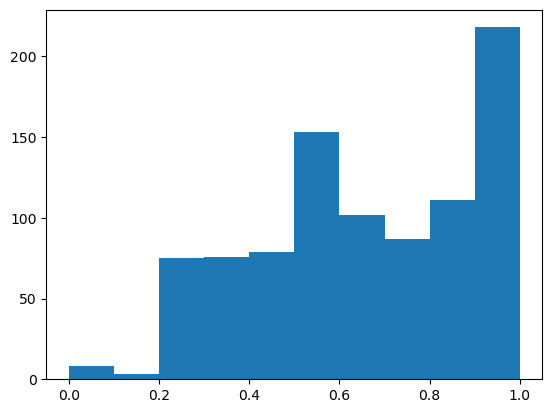

In [55]:
plt.hist(reac_df_add['match_score'])

(3049, 6)


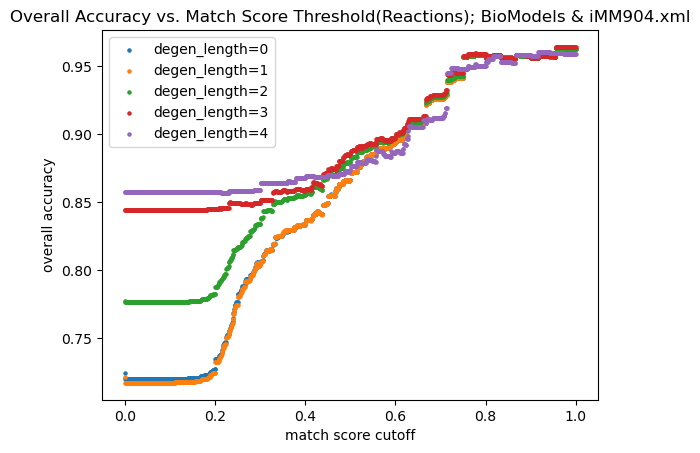

In [57]:
reac_ml_df2 = pd.concat([reac_ml_df, reac_df_add2])
print(reac_ml_df2.shape)

cutoffs = np.arange(0.0, 1.05, step=0.001)

vals = dict()
for one_degen in range(0, 5):
  ys = []
  xs = []
  val_tuples = []
  df = reac_ml_df2[reac_ml_df2['num_query_elements']>one_degen]
  for one_c in cutoffs:
    xs.append(one_c)
    sub_df = df[df['match_score']>=one_c]
    prop_accuracy = np.mean(sub_df['accuracy'])
    ys.append(prop_accuracy)
    val_tuples.append((one_c, prop_accuracy))
  vals[str(one_degen)] = val_tuples
  plt.scatter(xs, ys, s=5, label='degen_length=%d'%one_degen)
plt.legend()
plt.xlabel('match score cutoff')
plt.ylabel('overall accuracy')
plt.title("Overall Accuracy vs. Match Score Threshold(Reactions); BioModels & iMM904.xml")

# # print([val for val in val_tuples if val[1]>=0.95][0])
FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')
plt.savefig(os.path.join(TEMPFIG_DIR, 'accuracy_vs_score_reactions_biomd_iMM904.png'), dpi=300,
            bbox_inches='tight', pad_inches=0.0)

## Now do for all BiGG models, for species/reactions

In [78]:
model_names = []
len_names = []
num_cands = []
num_formulas = []
match_scores = []
is_correct_included = []
#
one_bigg = 'iMM904.xml'
for idx, one_bigg in enumerate(biggs):
  if idx % 30 == 0:
    print("We are at: %d" % idx)
  one_fpath = os.path.join(BIGG_DIR, one_bigg)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  specs2evaluate = list(recom.species.exist_annotation_formula.keys())

  recoms = recom.getSpeciesListRecommendation(pred_ids=recom.species.exist_annotation_formula.keys())
  recalls = recom.getSpeciesStatistics(model_mean=False)[cn.RECALL]
  for one_recom in recoms:
    model_names.append(one_bigg)
    one_spec = one_recom.id
    len_names.append(len(recom.species.getNameToUse(one_spec)))
    num_cands.append(len(one_recom.candidates))
    num_formulas.append(len(recom.species.formula[one_recom.id]))
    match_scores.append(one_recom.candidates[0][1])
    if recalls[one_spec] > 0:
      is_correct_included.append(1)
    else:
      is_correct_included.append(0)
    
spec_bigg_df = pd.DataFrame({'model': model_names,
                             'name_length': len_names,
                             'num_candidates': num_cands,
                             'num_formulas': num_formulas,
                             'match_score': match_scores,
                             'accuracy': is_correct_included})

We are at: 0
We are at: 30
We are at: 60
We are at: 90


In [82]:
print(spec_bigg_df.shape)
print(len(np.unique(spec_bigg_df['model'])))
spec_bigg_df.tail()

(133233, 6)
108


,model,name_length,num_candidates,num_formulas,match_score,accuracy
133228,iEKO11_1354.xml,27,1,1,1.000,1
133229,iEKO11_1354.xml,48,1,1,1.000,1
133230,iEKO11_1354.xml,39,1,1,1.000,1
133231,iEKO11_1354.xml,25,1,1,0.857,0
133232,iEKO11_1354.xml,19,1,1,0.854,0


In [ ]:
# spec_bigg_df.to_csv(os.path.join(ACCURACY_DIR, 'bigg_individual_species_accuracy.csv'), index=False)

# spec_bigg_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'bigg_individual_species_accuracy.csv'))
# spec_bigg_df.shape

In [88]:
np.min(spec_bigg_df['match_score'])

0.774

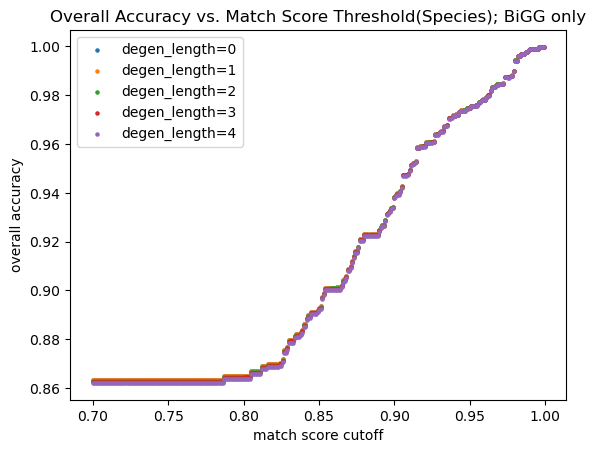

In [91]:
cutoffs = np.arange(0.7, 1.05, step=0.001)

one_degen = 4
vals = dict()

for one_degen in range(0, 5):
  ys = []
  xs = []
  val_tuples = []
  df = spec_bigg_df[spec_bigg_df['name_length']>one_degen]
  for one_c in cutoffs:
    xs.append(one_c)
    sub_df = df[df['match_score']>=one_c]
    prop_accuracy = np.mean(sub_df['accuracy'])
    ys.append(prop_accuracy)
    val_tuples.append((one_c, prop_accuracy))
  vals[str(one_degen)] = val_tuples
  plt.scatter(xs, ys, s=5, label='degen_length=%d'%one_degen)
plt.legend()
plt.xlabel('match score cutoff')
plt.ylabel('overall accuracy')
plt.title("Overall Accuracy vs. Match Score Threshold(Species); BiGG only")


FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')
plt.savefig(os.path.join(TEMPFIG_DIR, 'accuracy_vs_score_species_bigg.png'), dpi=300,
            bbox_inches='tight', pad_inches=0.0)

In [121]:
# By predicting reaction annotations from predicted species annotations :) 
def getRheaElementNum(inp_rhea, inp_df=ra.REF_MAT):
  """
  Get Number of elements of
  the given rhea term.
  
  Parameters
  ----------
  inp_rhea: str
  
  Returns
  -------
  : int
  """
  return len(inp_df.loc[inp_rhea, :].to_numpy().nonzero()[0])

# model_names = []
# num_rhea_eles = []
# num_query_eles = []
# num_candidates = []
# val_match_scores = []
# is_correct_included = []

In [122]:
for idx, one_bigg in enumerate(biggs[30:40]):
  if idx % 5 == 0:
    print("We are at", idx)
  one_fpath = os.path.join(BIGG_DIR, one_bigg)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  reac2evaluate = list(recom.reactions.exist_annotation.keys())
  if reac2evaluate:  
    recoms = recom.getReactionListRecommendation(pred_ids=reac2evaluate)
    recalls = recom.getReactionStatistics(model_mean=False)[cn.RECALL]
    for one_recom in recoms:
      reaction_id = one_recom.id
      match_scores = [val[1] for val in one_recom.candidates]
      num_ref_elements = [getRheaElementNum(val[0]) for val in one_recom.candidates]
      #
      mean_num_rhea_elements = np.mean(num_ref_elements)   
      # this is actually the number of reaction components;
      num_query_ele = len(recom.reactions.reaction_components[reaction_id])
      num_cands = len(match_scores)
      mean_match_score = np.mean(match_scores)
      #
      model_names.append(one_bigg)
      num_rhea_eles.append(mean_num_rhea_elements)
      num_query_eles.append(num_query_ele)
      num_candidates.append(num_cands)
      val_match_scores.append(mean_match_score)
      if recalls[reaction_id] > 0.0:
        is_correct_included.append(1)
      else:
        is_correct_included.append(0)

reac_bigg_df_pred_spec = pd.DataFrame({'model': model_names,
                                       'mean_num_rhea_elements': num_rhea_eles,
                                       'num_query_elements': num_query_eles,
                                       'num_candidates': num_candidates,
                                       'match_score': val_match_scores,
                                       'accuracy': is_correct_included})

We are at 0
We are at 5
We are at 10
We are at 15
We are at 20
We are at 25


,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
0,iCHOv1.xml,5.0,4,2,1.0,0
1,iCHOv1.xml,5.0,5,2,0.8,0
2,iCHOv1.xml,4.0,4,1,1.0,1
3,iCHOv1.xml,5.0,5,2,0.8,0
4,iCHOv1.xml,4.0,5,1,1.0,0


In [123]:
reac_bigg_df_pred_spec.tail()

,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
33866,iRC1080.xml,4.333333,5,3,0.733333,1
33867,iRC1080.xml,4.000000,4,2,1.000000,1
33868,iRC1080.xml,4.666667,4,3,0.433333,0
33869,iRC1080.xml,8.000000,8,1,1.000000,1
33870,iRC1080.xml,4.666667,4,3,0.433333,0


In [126]:
len(np.unique(reac_bigg_df_pred_spec['model']))

30

In [125]:
reac_bigg_df_pred_spec.to_csv(os.path.join(ACCURACY_DIR, 'bigg_individual_reactions_accuracy_predict_species.csv'), index=False)

# reac_bigg_df_pred_specreac_bigg_df_pred_spec = pd.read_csv(os.path.join(ACCURACY_DIR, 'bigg_individual_reactions_accuracy_predict_species.csv'))
# reac_bigg_df.shape

In [86]:
# Using existing species annotations; 
model_names = []
num_rhea_eles = []
num_query_eles = []
num_candidates = []
val_match_scores = []
is_correct_included = []


for idx, one_bigg in enumerate(biggs):
  if idx % 30 == 0:
    print("We are at: %d" % idx)
  one_fpath = os.path.join(BIGG_DIR, one_bigg)
  recom = recommender.Recommender(libsbml_fpath=one_fpath)
  reacs2eval_raw = list(recom.reactions.exist_annotation.keys())
  reacs2eval = []
  for one_r in reacs2eval_raw: 
    comps = recom.reactions.reaction_components[one_r]
    if all([val in recom.species.exist_annotation_formula.keys() \
              for val in comps]):
      reacs2eval.append(one_r)
  res = recom.reactions.predictAnnotation(inp_spec_dict=recom.species.exist_annotation_formula,
                                          inp_reac_list=reacs2eval,
                                          inp_ref_mat=ra.REF_MAT,
                                          update=False)

  for one_k in res['match_score']:
    reaction_id = one_k
    match_scores = [val[1] for val in res['match_score'][one_k]]
    num_ref_elements = [getRheaElementNum(val) for val in res['candidates'][one_k]]
    mean_num_rhea_elements = np.mean(num_ref_elements)   
    num_query_ele = len(recom.reactions.reaction_components[reaction_id])
    num_cands = len(match_scores)
    mean_match_score = np.mean(match_scores)
    model_names.append(one_bigg)
    num_rhea_eles.append(mean_num_rhea_elements)
    num_query_eles.append(num_query_ele)
    num_candidates.append(num_cands)
    val_match_scores.append(mean_match_score)
    if any(set(res['candidates'][one_k]).intersection(recom.reactions.exist_annotation[one_k])):
      is_correct_included.append(1)
    else:
      is_correct_included.append(0)

         
reac_bigg_df = pd.DataFrame({'model': model_names,
                             'mean_num_rhea_elements': num_rhea_eles,
                             'num_query_elements': num_query_eles,
                             'num_candidates': num_candidates,
                             'match_score': val_match_scores,
                             'accuracy': is_correct_included})
reac_bigg_df.tail()

We are at: 0
We are at: 30
We are at: 60
We are at: 90


,model,mean_num_rhea_elements,num_query_elements,num_candidates,match_score,accuracy
106239,iEKO11_1354.xml,5.000000,6,1,1.000000,1
106240,iEKO11_1354.xml,4.725000,2,120,0.228325,1
106241,iEKO11_1354.xml,5.000000,6,1,1.000000,1
106242,iEKO11_1354.xml,5.328571,2,70,0.224329,1
106243,iEKO11_1354.xml,5.000000,5,1,1.000000,1


In [99]:
reac_bigg_df.to_csv(os.path.join(ACCURACY_DIR, 'bigg_individual_reactions_accuracy_using_existing_species_annotations.csv'), index=False)

# reac_bigg_df = pd.read_csv(os.path.join(ACCURACY_DIR, 'bigg_individual_reactions_accuracy_using_existing_species_annotations.csv'))
# reac_bigg_df.shape

In [95]:
np.min(reac_bigg_df['match_score'])

0.184707182320442

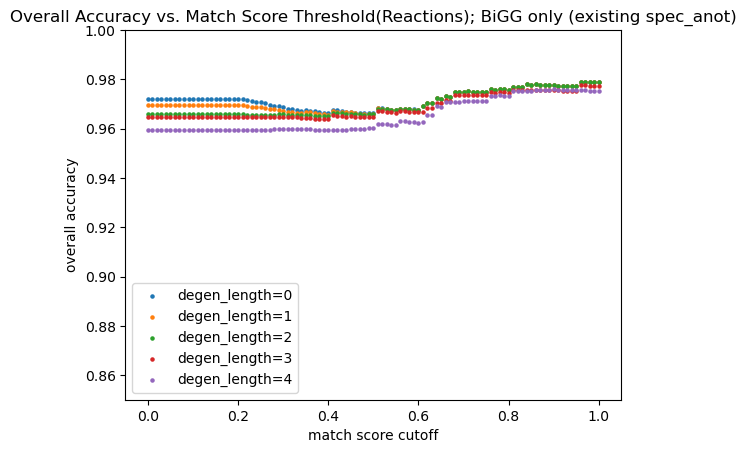

In [103]:
# Reaction - biggs only

cutoffs = np.arange(0.0, 1.05, step=0.01)


vals = dict()
for one_degen in range(0, 5):
  ys = []
  xs = []
  val_tuples = []
  df = reac_bigg_df[reac_bigg_df['num_query_elements']>one_degen]
  for one_c in cutoffs:
    xs.append(one_c)
    sub_df = df[df['match_score']>=one_c]
    prop_accuracy = np.mean(sub_df['accuracy'])
    ys.append(prop_accuracy)
    val_tuples.append((one_c, prop_accuracy))
  vals[str(one_degen)] = val_tuples
  plt.scatter(xs, ys, s=5, label='degen_length=%d'%one_degen)
plt.legend()
plt.ylim([0.85,1.0])
plt.xlabel('match score cutoff')
plt.ylabel('overall accuracy')
plt.title("Overall Accuracy vs. Match Score Threshold(Reactions); BiGG only (existing spec_anot)")

# # print([val for val in val_tuples if val[1]>=0.95][0])
FIGURE_DIR = '/Users/woosubs/Desktop/AutomateAnnotation/AMAS_suppl/figure_files'
TEMPFIG_DIR = os.path.join(FIGURE_DIR, 'temp')
plt.savefig(os.path.join(TEMPFIG_DIR, 'accuracy_vs_score_reactions_bigg.png'), dpi=300,
            bbox_inches='tight', pad_inches=0.0)

In [106]:
# spec_biomodels = np.unique(spec_ml_df['model'])

# all_vals_dict = dict()
# for idx, one_biomd in enumerate(spec_biomodels):
#   if idx % 50 == 0:
#     print("We are at %d." % idx)
#   one_fpath = os.path.join(BIOMODEL_DIR, one_biomd)
#   recom = recommender.Recommender(libsbml_fpath=one_fpath)
#   specs2eval = list(recom.species.exist_annotation_formula.keys())
#   # make recommendations (compute time)
#   recoms = recom.getSpeciesListRecommendation(pred_ids=specs2eval)
#   val_tups = []
#   for one_recom in recoms:
#     one_id = one_recom.id
#     used_name = recom.species.getNameToUse(one_id)
#     cands_chebi = [val[0] for val in one_recom.candidates]
#     cands_synonyms = list(itertools.chain(*[sa.CHEBI_LOW_SYNONYMS[val] for val in cands_chebi]))
#     # Can use the minimum synonym, instead of used_name
#     min_edit_distance = np.min([editdistance.eval(used_name.lower(), val) for val in cands_synonyms])
#     min_edit_terms = [val for val in cands_synonyms if editdistance.eval(used_name.lower(), val)==min_edit_distance]
#     new_min_edit_distance_norm = min_edit_distance/np.max([len(min_edit_terms[0]), len(used_name)])
#     mean_match_score = np.mean([val[1] for val in one_recom.candidates])
#     val_tups.append((new_min_edit_distance_norm, mean_match_score))
#   all_vals_dict[one_biomd] = val_tups

# res_dist = [np.mean([1-val[0] for val in all_vals_dict[k]]) for k in all_vals_dict.keys()]
# match_score = [np.mean([val[1] for val in all_vals_dict[k]]) for k in all_vals_dict.keys()]

# plt.xlim([-0.05,1.05])
# plt.ylim([-0.05,1.05])
# plt.scatter(match_score, res_dist)
# plt.title('BioModel Species: Predicted Term vs. Edit distance')

In [107]:
# all_vals_dict = dict()
# val_tups = []
# for one_recom in recoms:
#   one_id = one_recom.id
#   used_name = recom.species.getNameToUse(one_id)
#   cands_chebi = [val[0] for val in one_recom.candidates]
#   cands_synonyms = list(itertools.chain(*[sa.CHEBI_LOW_SYNONYMS[val] for val in cands_chebi]))
#   min_edit_distance = np.min([editdistance.eval(used_name.lower(), val) for val in cands_synonyms])
#   mean_match_score = np.mean([val[1] for val in one_recom.candidates])
#   val_tups.append((min_edit_distance, mean_match_score))

## Histogram of distribution of length of query terms. 